In [57]:
import os, sys
import pickle
import numpy as np  
import torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0,'../../LongTermEMG-master')
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")

# Train 

In [2]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
print("one group example ", np.shape(examples_datasets_train[0][0][0]))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))
print("one group label ", np.shape(labels_datasets_train[0][0][0]))

traning examples  (1, 4, 4)
one group example  (1009, 385)
traning labels  (1, 4, 4)
one group label  (1009,)


In [3]:
filter_size=None        
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycle_for_first_training=4               # #session
number_of_cycles_rest_of_training=4     
path_weight_to_save_to="Weights_TSD/TSD_DANN"      
gestures_to_remove=None                    
number_of_classes=11
batch_size=128          
spectrogram_model=False
feature_vector_input_length=385                     # size of one example 
learning_rate=0.002515

### DataLoader

In [21]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

def get_dataloader(examples_datasets, labels_datasets, number_of_cycle_for_first_training=2,
                   number_of_cycles_rest_of_training=2, batch_size=128,
                   drop_last=True, shuffle=True,
                   number_of_cycles_total=4, validation_set_ratio=0.1, get_validation_set=True, cycle_for_test=None,
                   ignore_first=False, gestures_to_remove=None):
    """
    X = signals
    Y = labels
    
    examples_datasets_train
    labels_datasets_train
    number_of_cycle_for_first_training:  #session for each training group 
    number_of_cycles_rest_of_training: totally four training groups
    batch_size (TensorDataset param)
    
    drop_last (TensorDataset param): when True, drop last batch if its size < batch_size (only used for taining)
    shuffle (TensorDataset param)
    
    number_of_cycles_total
    
    validation_set_ratio (train_test_split param): 
        ratio of validation set out of entire training data, the rest are training set 
    get_validation_set: return validation dataloader if True
    
    cycle_for_test: specify which cycle will be used for testing; no test dataloader returned if None
    
    ignore_first: ignore max_activatio training session (num=1) if True
    gestures_to_remove: None
    
    """
    participants_dataloaders, participants_dataloaders_validation, participants_dataloaders_test = [], [], []

    for participant_examples, participant_labels in zip(examples_datasets, labels_datasets):
        print("GET one participant_examples ", np.shape(participant_examples))
        dataloaders_trainings = []
        dataloaders_validations = []
        dataloaders_testing = []
        
        k = 0
        for training_index_examples, training_index_labels in zip(participant_examples, participant_labels):
            print("   GET one training_index_examples ", np.shape(training_index_examples), " at ", k)
            cycles_to_add_to_train = number_of_cycle_for_first_training
            if k > 0:
                cycles_to_add_to_train = number_of_cycles_rest_of_training
                
            X_associated_with_training_i, Y_associated_with_training_i = [], []
            X_test_associated_with_training_i, Y_test_associated_with_training_i = [], []
            for cycle in range(number_of_cycles_total):
                if (ignore_first is True and cycle != 1) or ignore_first is False:
                    examples_cycles = training_index_examples[cycle]
                    labels_cycles = training_index_labels[cycle]
                    print("      GET one examples_cycles ", np.shape(examples_cycles), " at ", cycle)
                    
                    if gestures_to_remove is not None:
                        examples_cycles, labels_cycles = remove_list_gestures_from_cycle(examples_cycles, labels_cycles,
                                                                                         gestures_to_remove=
                                                                                         gestures_to_remove)
                    if cycle < cycles_to_add_to_train:
                        X_associated_with_training_i.extend(examples_cycles)
                        Y_associated_with_training_i.extend(labels_cycles)
                    elif cycle_for_test is None:
                        X_test_associated_with_training_i.extend(examples_cycles)
                        Y_test_associated_with_training_i.extend(labels_cycles)
                    elif cycle == cycle_for_test:
                        X_test_associated_with_training_i.extend(examples_cycles)
                        Y_test_associated_with_training_i.extend(labels_cycles)

            print("   GOT one group XY ", np.shape(X_associated_with_training_i), "  ",  np.shape(Y_associated_with_training_i))
            print("       one group XY test ", np.shape(X_test_associated_with_training_i), "  ",  np.shape(X_test_associated_with_training_i))
            k += 1

            if get_validation_set:
                # Shuffle X and Y and separate them in a train and validation set.
                X, X_valid, Y, Y_valid = train_test_split(X_associated_with_training_i, Y_associated_with_training_i,
                                                          test_size=validation_set_ratio, shuffle=True)
            else:
                X, Y = X_associated_with_training_i, Y_associated_with_training_i
            print("       one group XY train", np.shape(X), "  ",  np.shape(Y))
            print("       one group XY valid", np.shape(X_valid), "  ",  np.shape(X_valid))
            
            # trainning dataloader
            train = TensorDataset(torch.from_numpy(np.array(X, dtype=np.float32)),
                                  torch.from_numpy(np.array(Y, dtype=np.int64)))
            trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=shuffle,
                                                      drop_last=drop_last)
            dataloaders_trainings.append(trainloader)
            
            # validation dataloader
            if get_validation_set:
                validation = TensorDataset(torch.from_numpy(np.array(X_valid, dtype=np.float32)),
                                           torch.from_numpy(np.array(Y_valid, dtype=np.int64)))
                validationloader = torch.utils.data.DataLoader(validation, batch_size=len(X_valid), shuffle=shuffle,
                                                               drop_last=False)
                dataloaders_validations.append(validationloader)

            # testing dataloader 
            if len(X_test_associated_with_training_i) > 0:
                test = TensorDataset(torch.from_numpy(np.array(X_test_associated_with_training_i, dtype=np.float32)),
                                     torch.from_numpy(np.array(Y_test_associated_with_training_i, dtype=np.int64)))
                testLoader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False,
                                                         drop_last=False)
                dataloaders_testing.append(testLoader)

        participants_dataloaders.append(dataloaders_trainings)
        if get_validation_set:
            participants_dataloaders_validation.append(dataloaders_validations)
        participants_dataloaders_test.append(dataloaders_testing)
        print("dataloaders: ")
        print("   train ", np.shape(participants_dataloaders))
        print("   valid ", np.shape(participants_dataloaders_validation))
        print("   test ", np.shape(participants_dataloaders_test))

    return participants_dataloaders, participants_dataloaders_validation, participants_dataloaders_test

In [18]:
def load_dataloaders_training_sessions(examples_datasets_train, labels_datasets_train,
                                       number_of_cycle_for_first_training=2, number_of_cycles_rest_of_training=2,
                                       batch_size=128, drop_last=True, shuffle=True, get_validation_set=True,
                                       cycle_for_test=None, ignore_first=False, gestures_to_remove=None):
    """
    examples_datasets_train
    labels_datasets_train
    number_of_cycle_for_first_training:  #session for each training group 
    number_of_cycles_rest_of_training: totally four training groups
    batch_size
    
    drop_last
    shuffle
    get_validation_set: return validation dataloader if True
    cycle_for_test: specify which cycle will be used for testing; no test dataloader returned if None
    
    ignore_first: ignore max_activatio training session (num=1) if True
    gestures_to_remove: None
    
    Return: 
        fource training dataloader and four validation dataloader 
    """
    train, validation, test = get_dataloader(examples_datasets_train, labels_datasets_train,
                                             number_of_cycle_for_first_training=number_of_cycle_for_first_training,
                                             number_of_cycles_rest_of_training=number_of_cycles_rest_of_training, 
                                             batch_size=batch_size,
                                             drop_last=drop_last, shuffle=shuffle,
                                             get_validation_set=get_validation_set,
                                             cycle_for_test=cycle_for_test,
                                             ignore_first=ignore_first,
                                             gestures_to_remove=gestures_to_remove)

    return train, validation, test

In [19]:
participants_train, participants_validation, _ = load_dataloaders_training_sessions(
    examples_datasets_train, labels_datasets_train, batch_size=batch_size,
    number_of_cycle_for_first_training=number_of_cycle_for_first_training,
    number_of_cycles_rest_of_training=number_of_cycles_rest_of_training, 
    gestures_to_remove=gestures_to_remove,
    ignore_first=True)

GET one participant_examples  (4, 4)
   GET one training_index_examples  (4,)  at  0
      GET one examples_cycles  (1009, 385)  at  0
      GET one examples_cycles  (949, 385)  at  2
      GET one examples_cycles  (1014, 385)  at  3
   GOT one group XY  (2972, 385)    (2972,)
   GOT one group XY test  (0,)    (0,)
       one group XY train (2674, 385)    (2674,)
       one group XY valid (298, 385)    (298, 385)
   GET one training_index_examples  (4,)  at  1
      GET one examples_cycles  (1064, 385)  at  0
      GET one examples_cycles  (1063, 385)  at  2
      GET one examples_cycles  (1017, 385)  at  3
   GOT one group XY  (3144, 385)    (3144,)
   GOT one group XY test  (0,)    (0,)
       one group XY train (2829, 385)    (2829,)
       one group XY valid (315, 385)    (315, 385)
   GET one training_index_examples  (4,)  at  2
      GET one examples_cycles  (1067, 385)  at  0
      GET one examples_cycles  (1067, 385)  at  2
      GET one examples_cycles  (1068, 385)  at  3
   G

In [7]:
print("size of last tain dataloader for last participant ", len(participants_train[-1][-1].dataset))
print("size of last valid dataloader for last participant ", len(participants_validation[-1][-1].dataset))

dataiter = iter(participants_train[-1][-1])
signals, labels = dataiter.next()

print(signals.shape, '---', labels.shape)   # batch_size = 128
print(signals[-1].shape, '---', labels[-1])

# each dataloader corresponds to one model training session 

size of last tain dataloader for last participant  2821
size of last valid dataloader for last participant  314
torch.Size([128, 385]) --- torch.Size([128])
torch.Size([385]) --- tensor(8)


### Model

### Start Train

In [12]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master")
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import load_checkpoint
from LongTermClassificationMain.Models.model_training import train_model_standard

import torch
import torch.nn as nn
import torch.optim as optim

os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")

for participant_i in range(len(participants_train)):
    print("Participant: ", participant_i)
    for session_j in range(0, len(participants_train[participant_i])):
        print("Session: ", session_j)
        # Define Model
        model = TSD_Network(number_of_class=number_of_classes, num_neurons=num_kernels,
                                feature_vector_input_length=feature_vector_input_length)

        # Define Loss functions
        cross_entropy_loss_classes = nn.CrossEntropyLoss(reduction='mean')

        # Define Optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

        # Define Scheduler
        precision = 1e-8
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=.2, patience=5,
                                                         verbose=True, eps=precision)

        if session_j > 0:
            # Fine-tune from the previous training
            model, _, _, start_epoch = load_checkpoint(
                model=model, optimizer=None, scheduler=None,
                filename=path_weight_to_save_to +
                         "/participant_%d/best_state_%d.pt" %
                         (participant_i, session_j - 1))

        best_state = train_model_standard(model=model, criterion=cross_entropy_loss_classes, optimizer=optimizer,
                                          scheduler=scheduler,
                                          dataloaders={"train": participants_train[participant_i][session_j],
                                                       "val": participants_validation[participant_i][session_j]},
                                          precision=precision, patience=10, patience_increase=10)

        if not os.path.exists(path_weight_to_save_to + "/participant_%d" % participant_i):
            os.makedirs(path_weight_to_save_to + "/participant_%d" % participant_i)
        torch.save(best_state, f=path_weight_to_save_to +
                                 "/participant_%d/best_state_%d.pt"
                                 % (participant_i, session_j))

Participant:  0
Session:  0
Number Parameters:  162013
Epoch 0/499
----------
train Loss: 0.01063568 Acc: 0.58085937
val Loss: 0.00678623 Acc: 0.40604027
New best validation loss: 0.006786228826382016
Epoch 1 of 500 took 0.245s
Epoch 1/499
----------
train Loss: 0.00527268 Acc: 0.80546875
val Loss: 0.01377121 Acc: 0.23154362
Epoch 2 of 500 took 0.172s
Epoch 2/499
----------
train Loss: 0.00405301 Acc: 0.85429687
val Loss: 0.01203972 Acc: 0.2852349
Epoch 3 of 500 took 0.178s
Epoch 3/499
----------
train Loss: 0.00344460 Acc: 0.865625
val Loss: 0.00422998 Acc: 0.70805369
New best validation loss: 0.004229978426990893
Epoch 4 of 500 took 0.181s
Epoch 4/499
----------
train Loss: 0.00292405 Acc: 0.89140625
val Loss: 0.00942227 Acc: 0.4295302
Epoch 5 of 500 took 0.199s
Epoch 5/499
----------
train Loss: 0.00295011 Acc: 0.88320312
val Loss: 0.00851000 Acc: 0.56040268
Epoch 6 of 500 took 0.222s
Epoch 6/499
----------
train Loss: 0.00260905 Acc: 0.903125
val Loss: 0.00462683 Acc: 0.70805369
Ep

Epoch 11 of 500 took 0.195s
Epoch 11/499
----------
train Loss: 0.00111865 Acc: 0.95987216
val Loss: 0.00059376 Acc: 0.94285714
New best validation loss: 0.0005937591431632875
Epoch 12 of 500 took 0.228s
Epoch 12/499
----------
train Loss: 0.00096822 Acc: 0.9634233
val Loss: 0.00098074 Acc: 0.90793651
Epoch 13 of 500 took 0.211s
Epoch 13/499
----------
train Loss: 0.00108505 Acc: 0.95703125
val Loss: 0.00069757 Acc: 0.93015873
Epoch 14 of 500 took 0.222s
Epoch 14/499
----------
train Loss: 0.00102909 Acc: 0.95809659
val Loss: 0.00050530 Acc: 0.95873016
New best validation loss: 0.0005052990383572049
Epoch 15 of 500 took 0.225s
Epoch 15/499
----------
train Loss: 0.00099450 Acc: 0.95774148
val Loss: 0.00077577 Acc: 0.91428571
Epoch 16 of 500 took 0.271s
Epoch 16/499
----------
train Loss: 0.00096871 Acc: 0.9609375
val Loss: 0.00060676 Acc: 0.94920635
Epoch 17 of 500 took 0.253s
Epoch 17/499
----------
train Loss: 0.00102020 Acc: 0.9609375
val Loss: 0.00109824 Acc: 0.8952381
Epoch 18 of 

train Loss: 0.00032449 Acc: 0.98757102
val Loss: 0.00015051 Acc: 0.98442368
New best validation loss: 0.00015051144166527508
Epoch 27 of 500 took 0.193s
Epoch 27/499
----------
train Loss: 0.00034255 Acc: 0.98757102
val Loss: 0.00016081 Acc: 0.98753894
Epoch 28 of 500 took 0.214s
Epoch 28/499
----------
train Loss: 0.00034944 Acc: 0.98544034
val Loss: 0.00017903 Acc: 0.98130841
Epoch 29 of 500 took 0.229s
Epoch 29/499
----------
train Loss: 0.00039481 Acc: 0.9818892
val Loss: 0.00013989 Acc: 0.98753894
New best validation loss: 0.00013988796981324287
Epoch 30 of 500 took 0.226s
Epoch 30/499
----------
train Loss: 0.00033752 Acc: 0.9868608
val Loss: 0.00024055 Acc: 0.96884735
Epoch 31 of 500 took 0.236s
Epoch 31/499
----------
train Loss: 0.00035991 Acc: 0.98615057
val Loss: 0.00017178 Acc: 0.98442368
Epoch 32 of 500 took 0.236s
Epoch 32/499
----------
train Loss: 0.00043015 Acc: 0.98508523
val Loss: 0.00014516 Acc: 0.99065421
Epoch 33 of 500 took 0.193s
Epoch 33/499
----------
train Lo

### Test on Train Set

In [23]:
cycle_for_test=3    # use third session for testing
_, _, participants_test = load_dataloaders_training_sessions(examples_datasets_train, labels_datasets_train,
                                                                 batch_size=512, cycle_for_test=cycle_for_test,
                                                                 gestures_to_remove=gestures_to_remove)

GET one participant_examples  (4, 4)
   GET one training_index_examples  (4,)  at  0
      GET one examples_cycles  (1009, 385)  at  0
      GET one examples_cycles  (1052, 385)  at  1
      GET one examples_cycles  (949, 385)  at  2
      GET one examples_cycles  (1014, 385)  at  3
   GOT one group XY  (2061, 385)    (2061,)
       one group XY test  (1014, 385)    (1014, 385)
       one group XY train (1854, 385)    (1854,)
       one group XY valid (207, 385)    (207, 385)
   GET one training_index_examples  (4,)  at  1
      GET one examples_cycles  (1064, 385)  at  0
      GET one examples_cycles  (1046, 385)  at  1
      GET one examples_cycles  (1063, 385)  at  2
      GET one examples_cycles  (1017, 385)  at  3
   GOT one group XY  (2110, 385)    (2110,)
       one group XY test  (1017, 385)    (1017, 385)
       one group XY train (1899, 385)    (1899,)
       one group XY valid (211, 385)    (211, 385)
   GET one training_index_examples  (4,)  at  2
      GET one examples_cyc

In [25]:
print("size of last test dataloader for last participant ", len(participants_test[-1][-1].dataset))

dataiter = iter(participants_test[-1][-1])
signals, labels = dataiter.next()

print(signals.shape, '---', labels.shape)   # batch_size = 128*4 = 512
print(signals[-1].shape, '---', labels[-1])

# each dataloader corresponds to one model training session 

size of last test dataloader for last participant  1049
torch.Size([512, 385]) --- torch.Size([512])
torch.Size([385]) --- tensor(5)


In [46]:
num_neurons = [200, 200, 200]   
use_only_first_training=True
path_weights=path_weight_to_save_to
algo_name = "standard_TSD"
"""
num_neurons (TSD model params)
feature_vector_input_length: size of one example (=385)

path_weights: where to load weights from
algo_name: where to save results

use_only_first_training: 
    load weights from first trainning session only if True; 
    otherwise use fine tunning weights (trained from all four sessions)
cycle_for_test: which session to use for testing
"""

model_outputs = []
predictions = []
ground_truths = []
accuracies = []

for participant_index, dataset_test in enumerate(participants_test):
    model_outputs_participant = []
    predictions_participant = []
    ground_truth_participant = []
    accuracies_participant = []
    
    # get model
    model = TSD_Network(number_of_class=number_of_classes, feature_vector_input_length=feature_vector_input_length,
                        num_neurons=num_neurons)
    
    # start test
    for session_index, training_session_test_data in enumerate(dataset_test):
        print(session_index, " SESSION   data = ", len(training_session_test_data.dataset))
        if use_only_first_training:
            best_state = torch.load(
                path_weights + "/participant_%d/best_state_%d.pt" %
                (participant_index, 0))
        else:
            best_state = torch.load(
                path_weights + "/participant_%d/best_state_%d.pt" %
                (participant_index, session_index))
        best_weights = best_state['state_dict']
        
        # load trained model
        model.load_state_dict(best_weights)
        
        # compare prediction and ground truth
        predictions_training_session = []
        ground_truth_training_sesssion = []
        model_outputs_session = []
        with torch.no_grad():
            # https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
            model.eval()
            for inputs, labels in training_session_test_data:
                inputs = inputs
                output = model(inputs)
                _, predicted = torch.max(output.data, 1)
                model_outputs_session.extend(torch.softmax(output, dim=1).cpu().numpy())
                predictions_training_session.extend(predicted.cpu().numpy())
                ground_truth_training_sesssion.extend(labels.numpy())
                print("   one batch ", predicted.shape)
        print("Participant: ", participant_index, " Accuracy: ",
              np.mean(np.array(predictions_training_session) == np.array(ground_truth_training_sesssion)))
        predictions_participant.append(predictions_training_session)
        model_outputs_participant.append(model_outputs_session)
        ground_truth_participant.append(ground_truth_training_sesssion)
        accuracies_participant.append(np.mean(np.array(predictions_training_session) ==
                                              np.array(ground_truth_training_sesssion)))
    accuracies.append(np.array(accuracies_participant))
    predictions.append(predictions_participant)
    model_outputs.append(model_outputs_participant)
    ground_truths.append(ground_truth_participant)
    print("ACCURACY PARTICIPANT ", participant_index, ": ", accuracies_participant)

Number Parameters:  162013
0  SESSION   data =  1014
   one batch  torch.Size([512])
   one batch  torch.Size([502])
Participant:  0  Accuracy:  0.9990138067061144
1  SESSION   data =  1017
   one batch  torch.Size([512])
   one batch  torch.Size([505])
Participant:  0  Accuracy:  0.6047197640117994
2  SESSION   data =  1068
   one batch  torch.Size([512])
   one batch  torch.Size([512])
   one batch  torch.Size([44])
Participant:  0  Accuracy:  0.6713483146067416
3  SESSION   data =  1049
   one batch  torch.Size([512])
   one batch  torch.Size([512])
   one batch  torch.Size([25])
Participant:  0  Accuracy:  0.5958055290753098
ACCURACY PARTICIPANT  0 :  [0.9990138067061144, 0.6047197640117994, 0.6713483146067416, 0.5958055290753098]


In [48]:
accuracies_to_display = []
for accuracies_from_participant in np.array(accuracies).flatten():
    accuracies_to_display.append(accuracies_from_participant)
print(accuracies_to_display)
print("OVERALL ACCURACY: " + str(np.mean(accuracies_to_display)))

[0.9990138067061144, 0.6047197640117994, 0.6713483146067416, 0.5958055290753098]
OVERALL ACCURACY: 0.7177218535999913


In [52]:
file_to_open = "results_tsd/" + algo_name + "_no_retraining.txt"
np.save("results_tsd/predictions_" + algo_name + "_no_retraining", np.array((ground_truths, 
                                                                            predictions, 
                                                                            model_outputs), dtype=object))

In [55]:
results_filename = "results_tsd/predictions_" + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

TSD_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    TSD_acc[i] = acc
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
TSD_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,0.999014,0.60472,0.671348,0.595806


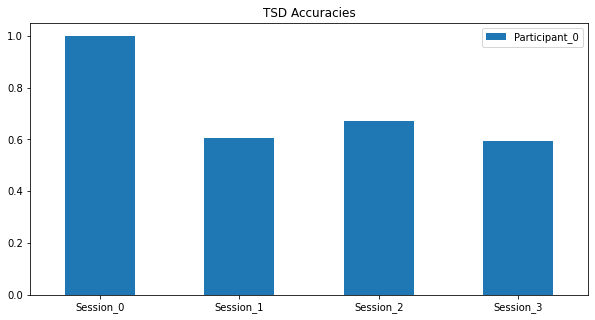

In [58]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()